In [2]:
options(warn=-1)

library(ppcor)
#install.packages('lmPerm')
library(lmPerm)
library(psych)
library(car)
library(ggplot2)
library(lme4)
library(mediation)
library(caret)
library(gbm)
library(party)
library(Metrics)
#install.packages("wesanderson")
library(wesanderson)
library(gtools)
library(interactions)
#install.packages('ggstance')
library(ggstance)
#install.packages('elasticnet')
#install.packages('kernlab')
#install.packages('e1071')
#install.packages('MatchIt')
library(MatchIt)
library(dplyr)
library(ukbtools)
library(mediation)
library(lavaan)
#install.packages('MissMech')
#library(semTools)
#library(MissMech)
#install.packages('aod')
#library(aod)

# Read in the data 

In [3]:
di=read.table('/dagher/dagher11/filip/PRSOB/data/brain_data.csv', header=TRUE, na.strings = "", sep=',', quote = "\"")
cov19=read.table('/dagher/dagher11/filip/COVID/data/covid19_result.txt', header=TRUE, na.strings = "", sep='\t', quote = "\"")
cov19= cov19[order(cov19$result, decreasing=TRUE),] 

covidinf=cov19
covidinf=covidinf[!duplicated(covidinf$eid),]
cov_base=covidinf

death=read.table('/dagher/dagher11/filip/COVID/data/death_cause.txt', header=TRUE, na.strings = "", sep='\t', quote = "\"")
death=(death[death$level==1 & death$cause_icd10=='U071',]) # take only individuals whose primary cause of death was COVID

## Add hypertension and diabetes diagnosis

In [4]:
di$hypertension <- 0
for (i in as.numeric(grep('vascularheart_problems_diagnosed_by_doctor', colnames(di)))) { 
    di$hypertension[di[i] == 'High blood pressure'] <- 1 # Hypertension
}

# Mark participants who have diabetes - self-reported
di$diabetes <- 0
for (i in as.numeric(grep('diabetes_diagnosed_by_doctor', colnames(di)))) { 
    di$diabetes[di[i] =="Yes"] <- 1
}

# Mark participants with hypertension - diagnosed
di$hypertension2 <- 0
for (i in as.numeric(grep('icd10', colnames(di)))) { 
    di$hypertension2[di[i] == 'I10 Essential (primary) hypertension'] <- 1 # Hypertension
    }

# Mark participants who have diabetes - diagnoses
exclusions_diabetes=c('^E11')
di$diabetes2 <- NA
for (i in as.numeric(grep('icd10', colnames(di)))) {
    for (d in 1:length(exclusions_diabetes)) {
        di$diabetes2[grepl(exclusions_diabetes[d], di[[i]])] = 1
    }
}

di$Hypertension=0
di$Hypertension[di$hypertension=='1' | di$hypertension2=='1']=1
di$Diabetes=0
di$Diabetes[di$diabetes=='1' | di$diabetes2=='1']=1

In [5]:
# Mark participants who have liver diseases
liver=c('^K7')
di$liver_disease <- 0
for (i in as.numeric(grep('icd10', colnames(di)))) {
    for (d in 1:length(liver)) {
        di$liver_disease[grepl(liver[d], di[[i]])] = 1
    }
}

# Mark participants who have liver diseases
cardiovascular=c('^I2','I3')
di$cardiovascular_disease <- 0
for (i in as.numeric(grep('icd10', colnames(di)))) {
    for (d in 1:length(cardiovascular)) {
        di$cardiovascular_disease[grepl(cardiovascular[d], di[[i]])] = 1
    }
}

# Mark participants who have liver diseases
pulmonary=c('^J')
di$pulmonary_disease <- 0
for (i in as.numeric(grep('icd10', colnames(di)))) {
    for (d in 1:length(pulmonary)) {
        di$pulmonary_disease[grepl(pulmonary[d], di[[i]])] = 1
    }
}

# Mark participants who have liver diseases
kidney=c('^N1')
di$kidney_disease <- 0
for (i in as.numeric(grep('icd10', colnames(di)))) {
    for (d in 1:length(kidney)) {
        di$kidney_disease[grepl(kidney[d], di[[i]])] = 1
    }
}



## Create metabolic syndrome variable based on https://www.ahajournals.org/doi/full/10.1161/CIRCULATIONAHA.109.192644

In [6]:
di$metabolic_syndrome <- 0

di[which(di$sex_31.0.0=="Female" & di$triglycerides_30870.0.0>1.7 & di$hdl_cholesterol_30760.0.0>1.3 & 
    rowMeans(cbind(di$systolic_blood_pressure_automated_reading_4080.0.0,
                                      di$systolic_blood_pressure_automated_reading_4080.0.1))>130 & 
    rowMeans(cbind(di$diastolic_blood_pressure_automated_reading_4079.0.0,
                                       di$diastolic_blood_pressure_automated_reading_4079.0.1))>85 &
    di$glucose_30740.0.0>5.6 &
    di$waist_circumference_48.0.0>80),"metabolic_syndrome"] <- 1

di[which(di$sex_31.0.0=="Male" & di$triglycerides_30870.0.0>1.7 & di$hdl_cholesterol_30760.0.0>1 & 
    rowMeans(cbind(di$systolic_blood_pressure_automated_reading_4080.0.0,
                                      di$systolic_blood_pressure_automated_reading_4080.0.1))>130 & 
    rowMeans(cbind(di$diastolic_blood_pressure_automated_reading_4079.0.0,
                                       di$diastolic_blood_pressure_automated_reading_4079.0.1))>85 &
    di$glucose_30740.0.0>5.6 &
    di$waist_circumference_48.0.0>94),"metabolic_syndrome"] <- 1

In [7]:
fasting=read.table('/dagher/dagher11/filip/COVID/data/glucose.csv',sep=',', header=T)
fasting=select(fasting,-c(eid))

# MetS latent variable and OR - covid infection

## Create dataframes

In [8]:
covidinf=merge(di, covidinf, by='eid')

covidinf$TG=(log(covidinf$triglycerides_30870.0.0))
covidinf$HDL=(log(covidinf$hdl_cholesterol_30760.0.0))
covidinf$Sex=as.factor(covidinf$sex_31.0.0)
covidinf$Waist=(covidinf$waist_circumference_48.0.0)
covidinf$HbA1c=(log(covidinf$glycated_haemoglobin_hba1c_30750.0.0))
covidinf$systolicBP=(rowMeans(cbind(covidinf$systolic_blood_pressure_automated_reading_4080.0.0,
                                      covidinf$systolic_blood_pressure_automated_reading_4080.0.1)))
covidinf$diastolicBP=(rowMeans(cbind(covidinf$diastolic_blood_pressure_automated_reading_4079.0.0,
                                       covidinf$diastolic_blood_pressure_automated_reading_4079.0.1)))
covidinf$glucose=(log(covidinf$glucose_30740.0.0))
covidinf$CRP=(log(covidinf$c.reactive_protein_30710.0.0))


COVinf=select(covidinf, TG, HDL, Sex, Hypertension, Diabetes, result,
          laboratory, origin, spectype, qualifications_6138.0.0, townsend_deprivation_index_at_recruitment_189.0.0,
          Waist, year_of_birth_34.0.0, smoking_status_20116.0.0,
          ethnic_background_21000.0.0, HbA1c, systolicBP, diastolicBP, glucose,
             average_total_household_income_before_tax_738.0.0, sex_31.0.0, CRP, eid,
             sex_31.0.0, year_of_birth_34.0.0, waist_circumference_48.0.0, hip_circumference_49.0.0,
              body_mass_index_bmi_21001.0.0, glucose_30740.0.0,glycated_haemoglobin_hba1c_30750.0.0,
              hdl_cholesterol_30760.0.0, pulmonary_disease, kidney_disease, cardiovascular_disease, liver_disease)



for (j in c(1, 2, 11, 12, 16, 17, 18, 19, 22)) { # 
    Q3=as.numeric(quantile(COVinf[j],0.75, na.rm=TRUE))
    Q1=as.numeric(quantile(COVinf[j],0.25, na.rm=TRUE))
    upper=Q3+(2.2*(Q3-Q1))
    lower=Q1-(2.2*(Q3-Q1))
    COVinf[j][COVinf[j]<lower]=NA
    COVinf[j][COVinf[j]>upper]=NA
    COVinf[j]=scale(COVinf[j])
}

COVinf=na.omit(COVinf)

COVinf$Hypertension=as.numeric(COVinf$Hypertension)
COVinf$Diabetes=as.numeric(COVinf$Diabetes)

nrow(COVinf)

COVinf=merge(COVinf,fasting, by=c('sex_31.0.0','year_of_birth_34.0.0', 'waist_circumference_48.0.0', 
                                  'hip_circumference_49.0.0','glucose_30740.0.0',
                                 'glycated_haemoglobin_hba1c_30750.0.0', 'hdl_cholesterol_30760.0.0'), all.x=TRUE)


COVinf$HDL=-1*COVinf$HDL

COVinf$glucose=resid(lm(glucose ~ fasting_time_74.0.0, data=COVinf))

[1] 12659

In [9]:
sum(COVinf$result)

[1] 1138

# Values before log-transformation

### SARS-CoV-2 positive

In [10]:
char_pos=merge(COVinf, covidinf, by='eid', all.x=TRUE)
char_pos=char_pos[char_pos$result.x==1,]
char=char_pos
table(char$result.x)/nrow(COVinf)
describe(char$year_of_birth_34.0.0.x)
table(char$sex_31.0.0.x)/nrow(char)
describe(char$waist_circumference_48.0.0.x)
describe(char$glycated_haemoglobin_hba1c_30750.0.0.x)
describe(char$c.reactive_protein_30710.0.0)
describe(char$glucose_30740.0.0.x)
describe(char$hdl_cholesterol_30760.0.0.x)
describe(char$triglycerides_30870.0.0)
describe((rowMeans(cbind(char$systolic_blood_pressure_automated_reading_4080.0.0,
                                      char$systolic_blood_pressure_automated_reading_4080.0.1))))
describe(rowMeans(cbind(char$diastolic_blood_pressure_automated_reading_4079.0.0,
                                       char$diastolic_blood_pressure_automated_reading_4079.0.1)))
table(char$Diabetes.x)/nrow(char)
table(char$Hypertension.x)/nrow(char) 
table(char$body_mass_index_bmi_21001.0.0.x>30)/nrow(char) 
table(char$metabolic_syndrome)/nrow(char) 
describe(char$body_mass_index_bmi_21001.0.0.x)
table(char$liver_disease.x)/nrow(char) 
table(char$pulmonary_disease.x)/nrow(char) 
table(char$cardiovascular_disease.x)/nrow(char) 
table(char$kidney_disease.x)/nrow(char) 


         1 
0.08989652 

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,1138,1952.304,9.127495,1951.5,1952.109,12.6021,1937,1969,32,0.1585154,-1.344796,0.2705705



  Female     Male 
0.473638 0.526362 

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,1138,93.38489,13.8909,93,92.93136,13.3434,62,142,80,0.3321258,0.1348789,0.4117745


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,1138,35.82935,4.505349,35.3,35.5716,3.85476,24,53.2,29.2,0.662114,1.039397,0.1335541


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,1138,3.000369,5.229767,1.59,1.991031,1.497426,0.09,63.93,63.84,6.35055,55.08959,0.1550284


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,1138,4.983326,0.6371266,4.916,4.936264,0.5404077,3.338,7.572,4.234,0.8172972,1.335378,0.01888664


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,1138,1.361864,0.3431419,1.3185,1.337944,0.3328437,0.511,2.954,2.443,0.70471,0.6325755,0.01017191


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,1138,1.788083,1.039995,1.521,1.640004,0.8087583,0.461,10.856,10.395,1.977366,7.691448,0.03082906


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,1138,137.1977,18.58658,134.5,136.2522,18.5325,91.5,204.5,113,0.5311468,0.220753,0.5509704


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,1138,82.45782,10.25369,82,82.30263,9.6369,48,118.5,70.5,0.2016658,0.2175487,0.3039547



         0          1 
0.90773286 0.09226714 


        0         1 
0.5834798 0.4165202 


   FALSE     TRUE 
0.698594 0.301406 


         0          1 
0.98418278 0.01581722 

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,1138,28.40323,5.152065,27.54255,27.94259,4.424523,16.2785,56.263,39.9845,1.026756,1.806507,0.152725



         0          1 
0.97539543 0.02460457 


        0         1 
0.7469244 0.2530756 


        0         1 
0.8506151 0.1493849 


         0          1 
0.92355009 0.07644991 

### SARS-CoV-2 negative

In [11]:
char_neg=merge(COVinf, covidinf, by='eid', all.x=TRUE)
char_neg=char_neg[char_neg$result.x==0,]
char=char_neg
table(char$result.x)/nrow(COVinf)
describe(char$year_of_birth_34.0.0.x)
table(char$sex_31.0.0.x)/nrow(char)
describe(char$waist_circumference_48.0.0.x)
describe(char$glycated_haemoglobin_hba1c_30750.0.0.x)
describe(char$c.reactive_protein_30710.0.0)
describe(char$glucose_30740.0.0.x)
describe(char$hdl_cholesterol_30760.0.0.x)
describe(char$triglycerides_30870.0.0)
describe((rowMeans(cbind(char$systolic_blood_pressure_automated_reading_4080.0.0,
                                      char$systolic_blood_pressure_automated_reading_4080.0.1))))
describe(rowMeans(cbind(char$diastolic_blood_pressure_automated_reading_4079.0.0,
                                       char$diastolic_blood_pressure_automated_reading_4079.0.1)))
table(char$Diabetes.x)/nrow(char)
table(char$Hypertension.x)/nrow(char) 
table(char$body_mass_index_bmi_21001.0.0.x>30)/nrow(char) 
table(char$metabolic_syndrome)/nrow(char) 
describe(char$body_mass_index_bmi_21001.0.0.x)
table(char$liver_disease.x)/nrow(char) 
table(char$pulmonary_disease.x)/nrow(char) 
table(char$cardiovascular_disease.x)/nrow(char) 
table(char$kidney_disease.x)/nrow(char) 


        0 
0.9101035 

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,11521,1950.016,8.128044,1948,1949.422,8.8956,1937,1970,33,0.5581258,-0.7645892,0.07572529



   Female      Male 
0.5232185 0.4767815 

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,11521,92.06818,13.68869,92,91.63175,13.3434,57,143,86,0.3247418,-0.03190711,0.1275313


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,11521,35.76357,4.327334,35.5,35.55213,3.7065,23.9,53.7,29.8,0.6563347,1.475758,0.0403158


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,11521,2.836558,4.447098,1.49,1.92271,1.378818,0.08,71.31,71.23,5.364848,43.26239,0.04143159


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,11521,5.003087,0.6286926,4.937,4.960785,0.5070492,3.292,7.568,4.276,0.8219338,1.662386,0.005857243


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,11521,1.432801,0.3845299,1.381,1.40333,0.3647196,0.53,3.524,2.994,0.841408,1.099048,0.003582491


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,11521,1.768551,1.015978,1.522,1.620799,0.7768824,0.272,10.664,10.392,1.982265,6.745047,0.009465405


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,11521,138.5533,18.55339,137,137.7761,18.5325,87,205,118,0.4141962,0.05438034,0.1728535


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,11521,82.23514,9.935423,82,82.05951,10.3782,49,119.5,70.5,0.1773649,0.01289526,0.09256382



         0          1 
0.92387814 0.07612186 


        0         1 
0.5767728 0.4232272 


    FALSE      TRUE 
0.7199028 0.2800972 


         0          1 
0.98437636 0.01562364 

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,11521,27.86858,4.902396,27.2392,27.48313,4.374263,15.2249,60.327,45.1021,0.9277503,1.622336,0.04567339



        0         1 
0.9737002 0.0262998 


       0        1 
0.747765 0.252235 


        0         1 
0.8377745 0.1622255 


         0          1 
0.93142956 0.06857044 

In [12]:
t.test(char_pos$waist_circumference_48.0.0.x,char_neg$waist_circumference_48.0.0.x)
t.test(char_pos$glycated_haemoglobin_hba1c_30750.0.0.x,char_neg$glycated_haemoglobin_hba1c_30750.0.0.x)
t.test(char_pos$c.reactive_protein_30710.0.0,char_neg$c.reactive_protein_30710.0.0)
t.test(char_pos$glucose_30740.0.0.x,char_neg$glucose_30740.0.0.x)
t.test(char_pos$hdl_cholesterol_30760.0.0.x,char_neg$hdl_cholesterol_30760.0.0.x)
t.test(char_pos$triglycerides_30870.0.0,char_neg$triglycerides_30870.0.0)
t.test(char_pos$systolicBP.x,char_neg$systolicBP.x)
t.test(char_pos$diastolicBP.x,char_neg$diastolicBP.x)
chisq.test(rbind(table(char_pos$sex_31.0.0.x),table(char_neg$sex_31.0.0.x)))
chisq.test(rbind(table(char_pos$Diabetes.x),table(char_neg$Diabetes.x)))
chisq.test(rbind(table(char_pos$Hypertension.x),table(char_neg$Hypertension.x)))
chisq.test(rbind(table(char_pos$metabolic_syndrome),table(char_neg$metabolic_syndrome)))
t.test(char_pos$year_of_birth_34.0.0.x,char_neg$year_of_birth_34.0.0.x)
t.test(char_pos$body_mass_index_bmi_21001.0.0.x,char_neg$body_mass_index_bmi_21001.0.0.x)
chisq.test(rbind(table(char_pos$pulmonary_disease.x),table(char_neg$pulmonary_disease.x)))
chisq.test(rbind(table(char_pos$cardiovascular_disease.x),table(char_neg$cardiovascular_disease.x)))
chisq.test(rbind(table(char_pos$kidney_disease.x),table(char_neg$kidney_disease.x)))
chisq.test(rbind(table(char_pos$liver_disease.x),table(char_neg$liver_disease.x)))
chisq.test(rbind(table(char_pos$body_mass_index_bmi_21001.0.0.x>30),table(char_neg$body_mass_index_bmi_21001.0.0.x>30)))



	Welch Two Sample t-test

data:  char_pos$waist_circumference_48.0.0.x and char_neg$waist_circumference_48.0.0.x
t = 3.0545, df = 1364.3, p-value = 0.002298
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.471069 2.162338
sample estimates:
mean of x mean of y 
 93.38489  92.06818 



	Welch Two Sample t-test

data:  char_pos$glycated_haemoglobin_hba1c_30750.0.0.x and char_neg$glycated_haemoglobin_hba1c_30750.0.0.x
t = 0.47151, df = 1352.6, p-value = 0.6374
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.2078938  0.3394515
sample estimates:
mean of x mean of y 
 35.82935  35.76357 



	Welch Two Sample t-test

data:  char_pos$c.reactive_protein_30710.0.0 and char_neg$c.reactive_protein_30710.0.0
t = 1.0208, df = 1304.6, p-value = 0.3075
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.1509954  0.4786166
sample estimates:
mean of x mean of y 
 3.000369  2.836558 



	Welch Two Sample t-test

data:  char_pos$glucose_30740.0.0.x and char_neg$glucose_30740.0.0.x
t = -0.99934, df = 1365, p-value = 0.3178
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.05855184  0.01902974
sample estimates:
mean of x mean of y 
 4.983326  5.003087 



	Welch Two Sample t-test

data:  char_pos$hdl_cholesterol_30760.0.0.x and char_neg$hdl_cholesterol_30760.0.0.x
t = -6.5778, df = 1434.4, p-value = 6.67e-11
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.09209247 -0.04978292
sample estimates:
mean of x mean of y 
 1.361864  1.432801 



	Welch Two Sample t-test

data:  char_pos$triglycerides_30870.0.0 and char_neg$triglycerides_30870.0.0
t = 0.60567, df = 1360.3, p-value = 0.5448
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.04373142  0.08279656
sample estimates:
mean of x mean of y 
 1.788083  1.768551 



	Welch Two Sample t-test

data:  char_pos$systolicBP.x and char_neg$systolicBP.x
t = -2.3476, df = 1370.5, p-value = 0.01904
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.13375621 -0.01197825
sample estimates:
    mean of x     mean of y 
-0.0730285201 -0.0001612903 



	Welch Two Sample t-test

data:  char_pos$diastolicBP.x and char_neg$diastolicBP.x
t = 0.70085, df = 1356.5, p-value = 0.4835
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.03978550  0.08401471
sample estimates:
  mean of x   mean of y 
0.026193455 0.004078849 



	Pearson's Chi-squared test with Yates' continuity correction

data:  rbind(table(char_pos$sex_31.0.0.x), table(char_neg$sex_31.0.0.x))
X-squared = 10.001, df = 1, p-value = 0.001565



	Pearson's Chi-squared test with Yates' continuity correction

data:  rbind(table(char_pos$Diabetes.x), table(char_neg$Diabetes.x))
X-squared = 3.5507, df = 1, p-value = 0.05952



	Pearson's Chi-squared test with Yates' continuity correction

data:  rbind(table(char_pos$Hypertension.x), table(char_neg$Hypertension.x))
X-squared = 0.16443, df = 1, p-value = 0.6851



	Pearson's Chi-squared test with Yates' continuity correction

data:  rbind(table(char_pos$metabolic_syndrome), table(char_neg$metabolic_syndrome))
X-squared = 1.8235e-29, df = 1, p-value = 1



	Welch Two Sample t-test

data:  char_pos$year_of_birth_34.0.0.x and char_neg$year_of_birth_34.0.0.x
t = 8.1426, df = 1321.3, p-value = 8.864e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 1.736620 2.839002
sample estimates:
mean of x mean of y 
 1952.304  1950.016 



	Welch Two Sample t-test

data:  char_pos$body_mass_index_bmi_21001.0.0.x and char_neg$body_mass_index_bmi_21001.0.0.x
t = 3.354, df = 1348.4, p-value = 0.0008186
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.2219404 0.8473707
sample estimates:
mean of x mean of y 
 28.40323  27.86858 



	Pearson's Chi-squared test with Yates' continuity correction

data:  rbind(table(char_pos$pulmonary_disease.x), table(char_neg$pulmonary_disease.x))
X-squared = 0.00070267, df = 1, p-value = 0.9789



	Pearson's Chi-squared test with Yates' continuity correction

data:  rbind(table(char_pos$cardiovascular_disease.x), table(char_neg$cardiovascular_disease.x))
X-squared = 1.1705, df = 1, p-value = 0.2793



	Pearson's Chi-squared test with Yates' continuity correction

data:  rbind(table(char_pos$kidney_disease.x), table(char_neg$kidney_disease.x))
X-squared = 0.8788, df = 1, p-value = 0.3485



	Pearson's Chi-squared test with Yates' continuity correction

data:  rbind(table(char_pos$liver_disease.x), table(char_neg$liver_disease.x))
X-squared = 0.059793, df = 1, p-value = 0.8068



	Pearson's Chi-squared test with Yates' continuity correction

data:  rbind(table(char_pos$body_mass_index_bmi_21001.0.0.x > 30), table(char_neg$body_mass_index_bmi_21001.0.0.x >     30))
X-squared = 2.2185, df = 1, p-value = 0.1364


## CFA

In [13]:
COVID_infection = '
#Latent variables

HypertensionLatent =~  diastolicBP + systolicBP  + Hypertension
DiabetesLatent =~ HbA1c + glucose  + Diabetes
DysL =~ a*TG + a*HDL

MetS =~ Waist + DysL + HypertensionLatent + DiabetesLatent + CRP

systolicBP ~~ diastolicBP
'


COVID_fitinf <- cfa(COVID_infection, data=COVinf, estimator='MLM')
summary(COVID_fitinf, standardized=TRUE, fit.measures=T)
#fitmeasures(WMHOB_fit) #fit indices

lavaan 0.6-7 ended normally after 47 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of free parameters                         23
                                                      
  Number of observations                         12659
                                                      
Model Test User Model:
                                              Standard      Robust
  Test Statistic                              1768.335    1664.406
  Degrees of freedom                                32          32
  P-value (Chi-square)                           0.000       0.000
  Scaling correction factor                                  1.062
       Satorra-Bentler correction                                 

Model Test Baseline Model:

  Test statistic                             25683.947   22785.971
  Degrees of freedom                                45          45
  P-value                        

## Logistic regression

In [14]:
### Get latent variable scores

COVinf$MetS=(lavPredict(COVID_fitinf, newdata = NULL, type = "lv", method = "regression",
           se = "none", acov = "none", label = TRUE, fsm = FALSE, 
           append.data = FALSE, assemble = FALSE,
           level = 1L, optim.method = "bfgs", ETA = NULL))[,4]

### Run logistic regression

metsinf_logit=(glm(result ~ townsend_deprivation_index_at_recruitment_189.0.0.x + 
           MetS +
           sex_31.0.0 +
           year_of_birth_34.0.0 +
           laboratory +
           spectype +
           qualifications_6138.0.0 + 
           smoking_status_20116.0.0 + 
           ethnic_background_21000.0.0 +
           average_total_household_income_before_tax_738.0.0 +
           pulmonary_disease +
           kidney_disease + 
           cardiovascular_disease +
           liver_disease, data=COVinf, family='binomial'(link="logit")))

summary(metsinf_logit)


Call:
glm(formula = result ~ townsend_deprivation_index_at_recruitment_189.0.0.x + 
    MetS + sex_31.0.0 + year_of_birth_34.0.0 + laboratory + spectype + 
    qualifications_6138.0.0 + smoking_status_20116.0.0 + ethnic_background_21000.0.0 + 
    average_total_household_income_before_tax_738.0.0 + pulmonary_disease + 
    kidney_disease + cardiovascular_disease + liver_disease, 
    family = binomial(link = "logit"), data = COVinf)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.2500  -0.4648  -0.3833  -0.3140   2.7415  

Coefficients:
                                                                                 Estimate
(Intercept)                                                                    -7.387e+01
townsend_deprivation_index_at_recruitment_189.0.0.x                             9.980e-02
MetS                                                                            9.769e-02
sex_31.0.0Male                                                           

In [15]:
exp(cbind(coef(metsinf_logit), confint(metsinf_logit)))

Waiting for profiling to be done...


,,2.5 %,97.5 %
(Intercept),8.303654e-33,5.017924e-40,1.400197e-25
townsend_deprivation_index_at_recruitment_189.0.0.x,1.104948e+00,1.032271e+00,1.182116e+00
MetS,1.102626e+00,9.959719e-01,1.220088e+00
sex_31.0.0Male,1.241026e+00,1.081661e+00,1.424343e+00
year_of_birth_34.0.0,1.037297e+00,1.028523e+00,1.046135e+00
laboratory,1.009736e+00,1.007820e+00,1.011653e+00
spectype,1.021766e+00,1.009486e+00,1.033913e+00
qualifications_6138.0.0College or University degree,9.341118e-01,7.391403e-01,1.187729e+00
qualifications_6138.0.0CSEs or equivalent,1.402866e+00,1.033600e+00,1.900124e+00
qualifications_6138.0.0None of the above,1.387307e+00,1.082249e+00,1.788331e+00


# MetS latent variable and OR - covid mortality

## Create dataframes

In [16]:
covidinf=cov_base
covidinf=covidinf[!duplicated(covidinf$eid),]
covidinf=merge(di, covidinf, by='eid')
cov_pos=(covidinf[covidinf$result==1,]) # take only people who tested positive
coviddeath=merge(cov_pos, death, by='eid',all.x=T) # merge with death records
coviddeath$level[is.na(coviddeath$level)]=0 # recode

In [17]:
coviddeath$TG=scale(log(coviddeath$triglycerides_30870.0.0))
coviddeath$HDL=scale(log(coviddeath$hdl_cholesterol_30760.0.0))
coviddeath$Sex=as.factor(coviddeath$sex_31.0.0)
coviddeath$Waist=scale(coviddeath$waist_circumference_48.0.0)
coviddeath$HbA1c=scale(log(coviddeath$glycated_haemoglobin_hba1c_30750.0.0))
coviddeath$systolicBP=scale(rowMeans(cbind(coviddeath$systolic_blood_pressure_automated_reading_4080.0.0,
                                      coviddeath$systolic_blood_pressure_automated_reading_4080.0.1)))
coviddeath$diastolicBP=scale(rowMeans(cbind(coviddeath$diastolic_blood_pressure_automated_reading_4079.0.0,
                                       coviddeath$diastolic_blood_pressure_automated_reading_4079.0.1)))
coviddeath$glucose=scale(log(coviddeath$glucose_30740.0.0))
coviddeath$CRP=scale(log(coviddeath$c.reactive_protein_30710.0.0))


COVinf=select(coviddeath, TG, HDL, Sex, Hypertension, Diabetes, result,
          laboratory, origin, spectype, qualifications_6138.0.0, townsend_deprivation_index_at_recruitment_189.0.0,
          Waist, year_of_birth_34.0.0, smoking_status_20116.0.0,
          ethnic_background_21000.0.0, HbA1c, systolicBP, diastolicBP, glucose,
             average_total_household_income_before_tax_738.0.0, sex_31.0.0, CRP, level, eid,
              sex_31.0.0, year_of_birth_34.0.0, waist_circumference_48.0.0, hip_circumference_49.0.0,
         glucose_30740.0.0,glycated_haemoglobin_hba1c_30750.0.0,
            hdl_cholesterol_30760.0.0, body_mass_index_bmi_21001.0.0, pulmonary_disease,
             liver_disease, kidney_disease, cardiovascular_disease)



for (j in c(1, 2, 11, 12, 16, 17, 18, 19, 22)) { # 
    Q3=as.numeric(quantile(COVinf[j],0.75, na.rm=TRUE))
    Q1=as.numeric(quantile(COVinf[j],0.25, na.rm=TRUE))
    upper=Q3+(2.2*(Q3-Q1))
    lower=Q1-(2.2*(Q3-Q1))
    COVinf[j][COVinf[j]<lower]=NA
    COVinf[j][COVinf[j]>upper]=NA
    COVinf[j]=scale(COVinf[j])
}


COVinf$Hypertension=as.numeric(COVinf$Hypertension)
COVinf$Diabetes=as.numeric(COVinf$Diabetes)

COVinf=na.omit(COVinf)

nrow(COVinf)

COVinf=merge(COVinf,fasting, by=c('sex_31.0.0','year_of_birth_34.0.0', 'waist_circumference_48.0.0', 
                                  'hip_circumference_49.0.0','glucose_30740.0.0',
                                 'hdl_cholesterol_30760.0.0','glycated_haemoglobin_hba1c_30750.0.0'), all.x=TRUE)

COVinf$HDL=-1*COVinf$HDL

COVinf$glucose=resid(lm(glucose ~ fasting_time_74.0.0, data=COVinf))



[1] 1148

In [18]:
sum(COVinf$level)

[1] 178

## Sample characteristics - values before transformations!

### COVID survivors

In [19]:
char_neg=merge(COVinf, coviddeath, by='eid', all.x=TRUE)
char_neg=char_neg[char_neg$level.x==0,]
char=char_neg
table(char$level.x)/nrow(char)
describe(char$year_of_birth_34.0.0.x)
table(char$sex_31.0.0.x)/nrow(char)
describe(char$waist_circumference_48.0.0.x)
describe(char$glycated_haemoglobin_hba1c_30750.0.0.x)
describe(char$c.reactive_protein_30710.0.0)
describe(char$glucose_30740.0.0.x)
describe(char$hdl_cholesterol_30760.0.0.x)
describe(char$triglycerides_30870.0.0)
describe((rowMeans(cbind(char$systolic_blood_pressure_automated_reading_4080.0.0,
                                      char$systolic_blood_pressure_automated_reading_4080.0.1))))
describe(rowMeans(cbind(char$diastolic_blood_pressure_automated_reading_4079.0.0,
                                       char$diastolic_blood_pressure_automated_reading_4079.0.1)))
table(char$Diabetes.x)/nrow(char)
table(char$Hypertension.x)/nrow(char)
table(char$body_mass_index_bmi_21001.0.0.x>30)/nrow(char)
table(char$metabolic_syndrome)/nrow(char)
describe(char$body_mass_index_bmi_21001.0.0.x)
table(char$liver_disease.x)/nrow(char)
table(char$pulmonary_disease.x)/nrow(char)
table(char$cardiovascular_disease.x)/nrow(char)
table(char$kidney_disease.x)/nrow(char)


0 
1 

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,970,1953.46,9.054071,1954,1953.481,11.8608,1937,1969,32,-0.01278608,-1.356257,0.2907087



   Female      Male 
0.4907216 0.5092784 

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,970,92.56093,13.62917,92.5,92.14704,12.6021,62,139,77,0.2993892,0.06318436,0.4376063


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,970,35.73206,4.626655,35.2,35.43686,3.85476,24,54.7,30.7,0.8107478,1.588849,0.1485529


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,970,2.820299,4.727931,1.545,1.890245,1.438122,0.09,63.37,63.28,6.284563,56.76046,0.1518047


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,970,4.953344,0.6282541,4.881,4.903487,0.5240991,3.269,7.812,4.543,0.9511864,1.964276,0.02017202


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,970,1.36487,0.349142,1.3215,1.340704,0.340998,0.511,2.954,2.443,0.6866855,0.5685714,0.01121028


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,970,1.776552,1.047466,1.5175,1.625921,0.8109822,0.461,10.856,10.395,2.095793,8.672378,0.03363212


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,970,135.6768,18.15016,133,134.6579,17.7912,91.5,204.5,113,0.5851949,0.3776066,0.5827664


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,970,82.19021,10.30065,81.5,82.03351,9.6369,48,118.5,70.5,0.2159258,0.2419122,0.3307339



         0          1 
0.91340206 0.08659794 


        0         1 
0.6185567 0.3814433 


    FALSE      TRUE 
0.7061856 0.2938144 


         0          1 
0.98762887 0.01237113 

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,970,28.21987,4.957904,27.4442,27.7976,4.321557,18.1955,54.3863,36.1908,0.9426556,1.455206,0.1591887



         0          1 
0.97319588 0.02680412 


        0         1 
0.7515464 0.2484536 


        0         1 
0.8659794 0.1340206 


         0          1 
0.92886598 0.07113402 

## COVID mortality group

In [20]:
char_pos=merge(COVinf, coviddeath, by='eid', all.x=TRUE)
char_pos=char_pos[char_pos$level.x==1,]
char=char_pos
table(char$level.x)/nrow(char)
describe(char$year_of_birth_34.0.0.x)
table(char$sex_31.0.0.x)/nrow(char)
describe(char$waist_circumference_48.0.0.x)
describe(char$glycated_haemoglobin_hba1c_30750.0.0.x)
describe(char$c.reactive_protein_30710.0.0)
describe(char$glucose_30740.0.0.x)
describe(char$hdl_cholesterol_30760.0.0.x)
describe(char$triglycerides_30870.0.0)
describe((rowMeans(cbind(char$systolic_blood_pressure_automated_reading_4080.0.0,
                                      char$systolic_blood_pressure_automated_reading_4080.0.1))))
describe(rowMeans(cbind(char$diastolic_blood_pressure_automated_reading_4079.0.0,
                                       char$diastolic_blood_pressure_automated_reading_4079.0.1)))
table(char$Diabetes.x)/nrow(char)
table(char$Hypertension.x)/nrow(char)
table(char$body_mass_index_bmi_21001.0.0.x>30)/nrow(char)
table(char$metabolic_syndrome)/nrow(char)
describe(char$body_mass_index_bmi_21001.0.0.x)
table(char$liver_disease.x)/nrow(char)
table(char$pulmonary_disease.x)/nrow(char)
table(char$cardiovascular_disease.x)/nrow(char)
table(char$kidney_disease.x)/nrow(char)


1 
1 

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,178,1945.713,6.271804,1944,1944.861,4.4478,1938,1966,28,1.165013,0.7943956,0.4700916



   Female      Male 
0.3651685 0.6348315 

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,178,98.49382,14.31479,97,98.08542,13.3434,68,142,74,0.3634926,0.1341182,1.072939


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,178,36.9382,5.186053,36.15,36.59722,4.22541,23.2,55.8,32.6,0.8262966,1.692996,0.3887111


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,178,4.009888,7.256367,2.1,2.611736,2.090466,0.1,63.93,63.83,5.48888,36.28048,0.5438877


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,178,5.201433,0.7431392,5.134,5.169382,0.6642048,3.431,7.498,4.067,0.4387478,0.2639085,0.05570064


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,178,1.341579,0.3086621,1.2995,1.321139,0.2883657,0.723,2.41,1.687,0.7339677,0.72603,0.0231352


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,178,1.881326,1.008673,1.628,1.747535,0.8072757,0.495,5.284,4.789,1.178204,0.8874791,0.07560321


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,178,145.736,18.42868,146.75,145.1181,18.16185,104,202.5,98.5,0.2734459,-0.01325026,1.381288


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,178,83.98876,10.0649,84.25,83.76736,9.6369,58.5,110.5,52,0.186352,0.08562666,0.7543959



        0         1 
0.8483146 0.1516854 


        0         1 
0.3764045 0.6235955 


    FALSE      TRUE 
0.6404494 0.3595506 


         0          1 
0.95505618 0.04494382 

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,178,29.56625,6.058656,28.4333,28.97581,4.944026,16.2785,56.263,39.9845,1.090487,1.736722,0.4541154



         0          1 
0.98314607 0.01685393 


        0         1 
0.7078652 0.2921348 


       0        1 
0.747191 0.252809 


        0         1 
0.8932584 0.1067416 

In [21]:
t.test(char_pos$waist_circumference_48.0.0.x,char_neg$waist_circumference_48.0.0.x)
t.test(char_pos$glycated_haemoglobin_hba1c_30750.0.0.x,char_neg$glycated_haemoglobin_hba1c_30750.0.0.x)
t.test(char_pos$c.reactive_protein_30710.0.0,char_neg$c.reactive_protein_30710.0.0)
t.test(char_pos$glucose_30740.0.0.x,char_neg$glucose_30740.0.0.x)
t.test(char_pos$hdl_cholesterol_30760.0.0.x,char_neg$hdl_cholesterol_30760.0.0.x)
t.test(char_pos$triglycerides_30870.0.0,char_neg$triglycerides_30870.0.0)
t.test(char_pos$systolicBP.x,char_neg$systolicBP.x)
t.test(char_pos$diastolicBP.x,char_neg$diastolicBP.x)
chisq.test(rbind(table(char_pos$sex_31.0.0.x),table(char_neg$sex_31.0.0.x)))
chisq.test(rbind(table(char_pos$Diabetes.x),table(char_neg$Diabetes.x)))
chisq.test(rbind(table(char_pos$Hypertension.x),table(char_neg$Hypertension.x)))
chisq.test(rbind(table(char_pos$metabolic_syndrome),table(char_neg$metabolic_syndrome)))
t.test(char_pos$year_of_birth_34.0.0.x,char_neg$year_of_birth_34.0.0.x)
t.test(char_pos$body_mass_index_bmi_21001.0.0.x,char_neg$body_mass_index_bmi_21001.0.0.x)
chisq.test(rbind(table(char_pos$pulmonary_disease.x),table(char_neg$pulmonary_disease.x)))
chisq.test(rbind(table(char_pos$cardiovascular_disease.x),table(char_neg$cardiovascular_disease.x)))
chisq.test(rbind(table(char_pos$kidney_disease.x),table(char_neg$kidney_disease.x)))
chisq.test(rbind(table(char_pos$liver_disease.x),table(char_neg$liver_disease.x)))
chisq.test(rbind(table(char_pos$body_mass_index_bmi_21001.0.0.x>30),table(char_neg$body_mass_index_bmi_21001.0.0.x>30)))



	Welch Two Sample t-test

data:  char_pos$waist_circumference_48.0.0.x and char_neg$waist_circumference_48.0.0.x
t = 5.1201, df = 239.57, p-value = 6.274e-07
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 3.650257 8.215528
sample estimates:
mean of x mean of y 
 98.49382  92.56093 



	Welch Two Sample t-test

data:  char_pos$glycated_haemoglobin_hba1c_30750.0.0.x and char_neg$glycated_haemoglobin_hba1c_30750.0.0.x
t = 2.8985, df = 231.58, p-value = 0.00411
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.3862555 2.0260253
sample estimates:
mean of x mean of y 
 36.93820  35.73206 



	Welch Two Sample t-test

data:  char_pos$c.reactive_protein_30710.0.0 and char_neg$c.reactive_protein_30710.0.0
t = 2.1067, df = 205.42, p-value = 0.03636
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.07628592 2.30289142
sample estimates:
mean of x mean of y 
 4.009888  2.820299 



	Welch Two Sample t-test

data:  char_pos$glucose_30740.0.0.x and char_neg$glucose_30740.0.0.x
t = 4.1878, df = 225.76, p-value = 4.04e-05
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.1313527 0.3648239
sample estimates:
mean of x mean of y 
 5.201433  4.953344 



	Welch Two Sample t-test

data:  char_pos$hdl_cholesterol_30760.0.0.x and char_neg$hdl_cholesterol_30760.0.0.x
t = -0.906, df = 267.18, p-value = 0.3658
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.07390773  0.02732483
sample estimates:
mean of x mean of y 
 1.341579  1.364870 



	Welch Two Sample t-test

data:  char_pos$triglycerides_30870.0.0 and char_neg$triglycerides_30870.0.0
t = 1.2662, df = 252.18, p-value = 0.2066
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.05818773  0.26773632
sample estimates:
mean of x mean of y 
 1.881326  1.776552 



	Welch Two Sample t-test

data:  char_pos$systolicBP.x and char_neg$systolicBP.x
t = 6.7097, df = 244.21, p-value = 1.349e-10
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.381435 0.698449
sample estimates:
 mean of x  mean of y 
 0.4216009 -0.1183410 



	Welch Two Sample t-test

data:  char_pos$diastolicBP.x and char_neg$diastolicBP.x
t = 2.1835, df = 249.89, p-value = 0.02993
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.01713785 0.33261341
sample estimates:
 mean of x  mean of y 
 0.1451191 -0.0297565 



	Pearson's Chi-squared test with Yates' continuity correction

data:  rbind(table(char_pos$sex_31.0.0.x), table(char_neg$sex_31.0.0.x))
X-squared = 9.0177, df = 1, p-value = 0.002674



	Pearson's Chi-squared test with Yates' continuity correction

data:  rbind(table(char_pos$Diabetes.x), table(char_neg$Diabetes.x))
X-squared = 6.5688, df = 1, p-value = 0.01038



	Pearson's Chi-squared test with Yates' continuity correction

data:  rbind(table(char_pos$Hypertension.x), table(char_neg$Hypertension.x))
X-squared = 35.24, df = 1, p-value = 2.915e-09



	Pearson's Chi-squared test with Yates' continuity correction

data:  rbind(table(char_pos$metabolic_syndrome), table(char_neg$metabolic_syndrome))
X-squared = 7.5161, df = 1, p-value = 0.006115



	Welch Two Sample t-test

data:  char_pos$year_of_birth_34.0.0.x and char_neg$year_of_birth_34.0.0.x
t = -14.015, df = 329.46, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -8.833613 -6.659008
sample estimates:
mean of x mean of y 
 1945.713  1953.460 



	Welch Two Sample t-test

data:  char_pos$body_mass_index_bmi_21001.0.0.x and char_neg$body_mass_index_bmi_21001.0.0.x
t = 2.7979, df = 222.56, p-value = 0.005594
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.3980709 2.2946882
sample estimates:
mean of x mean of y 
 29.56625  28.21987 



	Pearson's Chi-squared test with Yates' continuity correction

data:  rbind(table(char_pos$pulmonary_disease.x), table(char_neg$pulmonary_disease.x))
X-squared = 1.2886, df = 1, p-value = 0.2563



	Pearson's Chi-squared test with Yates' continuity correction

data:  rbind(table(char_pos$cardiovascular_disease.x), table(char_neg$cardiovascular_disease.x))
X-squared = 15.519, df = 1, p-value = 8.166e-05



	Pearson's Chi-squared test with Yates' continuity correction

data:  rbind(table(char_pos$kidney_disease.x), table(char_neg$kidney_disease.x))
X-squared = 2.2146, df = 1, p-value = 0.1367



	Pearson's Chi-squared test with Yates' continuity correction

data:  rbind(table(char_pos$liver_disease.x), table(char_neg$liver_disease.x))
X-squared = 0.26815, df = 1, p-value = 0.6046



	Pearson's Chi-squared test with Yates' continuity correction

data:  rbind(table(char_pos$body_mass_index_bmi_21001.0.0.x > 30), table(char_neg$body_mass_index_bmi_21001.0.0.x >     30))
X-squared = 2.7688, df = 1, p-value = 0.09612


## CFA

In [22]:
COVID_infection = '
#Latent variables

HypertensionLatent =~  diastolicBP + systolicBP  + Hypertension
DiabetesLatent =~ HbA1c + glucose  + Diabetes
DysL =~ a*TG + a*HDL

MetS =~ Waist + DysL + HypertensionLatent + DiabetesLatent + CRP

diastolicBP~~systolicBP
HbA1c ~~ glucose

'

COVID_fitinf <- cfa(COVID_infection, data=COVinf, estimator='MLM')
summary(COVID_fitinf, standardized=TRUE, fit.measures=T)
#fitmeasures(WMHOB_fit) #fit indices

lavaan 0.6-7 ended normally after 44 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of free parameters                         24
                                                      
  Number of observations                          1148
                                                      
Model Test User Model:
                                              Standard      Robust
  Test Statistic                               213.921     194.974
  Degrees of freedom                                31          31
  P-value (Chi-square)                           0.000       0.000
  Scaling correction factor                                  1.097
       Satorra-Bentler correction                                 

Model Test Baseline Model:

  Test statistic                              2371.116    2076.373
  Degrees of freedom                                45          45
  P-value                        

### Get latent variable scores

In [23]:
COVinf$MetS=(lavPredict(COVID_fitinf, newdata = NULL, type = "lv", method = "regression",
           se = "none", acov = "none", label = TRUE, fsm = FALSE, 
           append.data = FALSE, assemble = FALSE,
           level = 1L, optim.method = "bfgs", ETA = NULL))[,4]

### Run logistic regression

In [24]:
metsinf_logit=(glm(level ~ townsend_deprivation_index_at_recruitment_189.0.0.x + 
           MetS +
           sex_31.0.0 +
           year_of_birth_34.0.0 +
           laboratory +
           spectype +
           qualifications_6138.0.0 + 
           smoking_status_20116.0.0 + 
           ethnic_background_21000.0.0 +
           average_total_household_income_before_tax_738.0.0 +
           pulmonary_disease +
           kidney_disease + 
           cardiovascular_disease +
           liver_disease, data=COVinf, family='binomial'(link="logit")))

summary(metsinf_logit)


Call:
glm(formula = level ~ townsend_deprivation_index_at_recruitment_189.0.0.x + 
    MetS + sex_31.0.0 + year_of_birth_34.0.0 + laboratory + spectype + 
    qualifications_6138.0.0 + smoking_status_20116.0.0 + ethnic_background_21000.0.0 + 
    average_total_household_income_before_tax_738.0.0 + pulmonary_disease + 
    kidney_disease + cardiovascular_disease + liver_disease, 
    family = binomial(link = "logit"), data = COVinf)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5266  -0.5950  -0.3052  -0.1434   2.9017  

Coefficients:
                                                                                 Estimate
(Intercept)                                                                     2.434e+02
townsend_deprivation_index_at_recruitment_189.0.0.x                             1.294e-01
MetS                                                                            5.612e-01
sex_31.0.0Male                                                            

In [25]:
metsinf_logit_specfactors=(glm(level ~ townsend_deprivation_index_at_recruitment_189.0.0.x + 
           systolicBP + diastolicBP + Hypertension +
           glucose + HbA1c + Diabetes +
           HDL + TG +
           CRP +
           Waist +
           sex_31.0.0 +
           year_of_birth_34.0.0 +
           laboratory +
           spectype +
           qualifications_6138.0.0 + 
           smoking_status_20116.0.0 + 
           ethnic_background_21000.0.0 +
           average_total_household_income_before_tax_738.0.0 +
           pulmonary_disease +
           kidney_disease + 
           cardiovascular_disease +
           liver_disease, data=COVinf, family='binomial'(link="logit")))

summary(metsinf_logit_specfactors)


Call:
glm(formula = level ~ townsend_deprivation_index_at_recruitment_189.0.0.x + 
    systolicBP + diastolicBP + Hypertension + glucose + HbA1c + 
    Diabetes + HDL + TG + CRP + Waist + sex_31.0.0 + year_of_birth_34.0.0 + 
    laboratory + spectype + qualifications_6138.0.0 + smoking_status_20116.0.0 + 
    ethnic_background_21000.0.0 + average_total_household_income_before_tax_738.0.0 + 
    pulmonary_disease + kidney_disease + cardiovascular_disease + 
    liver_disease, family = binomial(link = "logit"), data = COVinf)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5314  -0.5767  -0.2983  -0.1338   2.8857  

Coefficients:
                                                                                 Estimate
(Intercept)                                                                     2.264e+02
townsend_deprivation_index_at_recruitment_189.0.0.x                             1.709e-01
systolicBP                                                            

### Get odds ratio with CIs

In [26]:
(ORs_MetS=exp(cbind(coef(metsinf_logit), confint(metsinf_logit)))  )

Waiting for profiling to be done...


,,2.5 %,97.5 %
(Intercept),5.162489e+105,8.132662e+79,1.423436e+133
townsend_deprivation_index_at_recruitment_189.0.0.x,1.138126e+00,9.282000e-01,1.392505e+00
MetS,1.752756e+00,1.302741e+00,2.365838e+00
sex_31.0.0Male,1.037536e+00,6.920487e-01,1.559686e+00
year_of_birth_34.0.0,8.822117e-01,8.541744e-01,9.094047e-01
laboratory,9.863446e-01,9.801501e-01,9.924435e-01
spectype,9.978767e-01,9.598823e-01,1.036356e+00
qualifications_6138.0.0College or University degree,1.241273e+00,5.828869e-01,2.790704e+00
qualifications_6138.0.0CSEs or equivalent,1.266080e+00,3.471692e-01,4.135394e+00
qualifications_6138.0.0None of the above,1.485455e+00,6.896808e-01,3.386388e+00


In [27]:
(ORs_mortality=exp(cbind(coef(metsinf_logit_specfactors), confint(metsinf_logit_specfactors)))  )

Waiting for profiling to be done...


,,2.5 %,97.5 %
(Intercept),2.139012e+98,4.011570e+70,4.230267e+127
townsend_deprivation_index_at_recruitment_189.0.0.x,1.186419e+00,9.628076e-01,1.459462e+00
systolicBP,1.316249e+00,1.020801e+00,1.700637e+00
diastolicBP,9.583817e-01,7.461671e-01,1.229698e+00
Hypertension,1.167884e+00,7.639748e-01,1.784772e+00
glucose,1.267762e+00,1.040219e+00,1.549932e+00
HbA1c,8.661323e-01,6.827958e-01,1.098485e+00
Diabetes,9.593196e-01,4.887716e-01,1.846370e+00
HDL,1.042551e+00,8.247975e-01,1.318359e+00
TG,9.369364e-01,7.456339e-01,1.174555e+00


## What does 1 unit change on latent variable MetS mean?

In [28]:
interpretation=merge(COVinf, coviddeath, by='eid', all.x=TRUE)
interpretation$SBP=rowMeans(cbind(interpretation$systolic_blood_pressure_automated_reading_4080.0.0,
                               interpretation$systolic_blood_pressure_automated_reading_4080.0.1))
interpretation$DBP=rowMeans(cbind(interpretation$diastolic_blood_pressure_automated_reading_4079.0.0,
                               interpretation$diastolic_blood_pressure_automated_reading_4079.0.1))

In [29]:
summary(lm(glucose_30740.0.0.x~MetS, data=interpretation))
summary(lm(SBP~MetS, data=interpretation))
summary(lm(DBP~MetS, data=interpretation))
summary(lm(glycated_haemoglobin_hba1c_30750.0.0.x~MetS, data=interpretation))
summary(lm(c.reactive_protein_30710.0.0~MetS, data=interpretation))
summary(lm(triglycerides_30870.0.0~MetS, data=interpretation))
summary(lm(hdl_cholesterol_30760.0.0.x~MetS, data=interpretation))
summary(lm(waist_circumference_48.0.0.x~MetS, data=interpretation))


Call:
lm(formula = glucose_30740.0.0.x ~ MetS, data = interpretation)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.81634 -0.41893 -0.06117  0.33622  2.69997 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.99181    0.01881 265.382  < 2e-16 ***
MetS         0.20628    0.02684   7.686 3.25e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.6373 on 1146 degrees of freedom
Multiple R-squared:  0.04902,	Adjusted R-squared:  0.04819 
F-statistic: 59.08 on 1 and 1146 DF,  p-value: 3.248e-14



Call:
lm(formula = SBP ~ MetS, data = interpretation)

Residuals:
    Min      1Q  Median      3Q     Max 
-40.622 -12.565  -2.085  11.208  71.112 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 137.2365     0.5271 260.357   <2e-16 ***
MetS          7.1728     0.7521   9.537   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 17.86 on 1146 degrees of freedom
Multiple R-squared:  0.07354,	Adjusted R-squared:  0.07273 
F-statistic: 90.96 on 1 and 1146 DF,  p-value: < 2.2e-16



Call:
lm(formula = DBP ~ MetS, data = interpretation)

Residuals:
    Min      1Q  Median      3Q     Max 
-30.897  -6.441  -0.383   6.345  32.955 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  82.4691     0.2904  284.00   <2e-16 ***
MetS          4.2728     0.4143   10.31   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 9.839 on 1146 degrees of freedom
Multiple R-squared:  0.08492,	Adjusted R-squared:  0.08412 
F-statistic: 106.4 on 1 and 1146 DF,  p-value: < 2.2e-16



Call:
lm(formula = glycated_haemoglobin_hba1c_30750.0.0.x ~ MetS, data = interpretation)

Residuals:
     Min       1Q   Median       3Q      Max 
-13.3659  -2.5742  -0.3077   2.3448  17.5528 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  35.9191     0.1230   292.0   <2e-16 ***
MetS          3.2123     0.1755    18.3   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.167 on 1146 degrees of freedom
Multiple R-squared:  0.2262,	Adjusted R-squared:  0.2256 
F-statistic: 335.1 on 1 and 1146 DF,  p-value: < 2.2e-16



Call:
lm(formula = c.reactive_protein_30710.0.0 ~ MetS, data = interpretation)

Residuals:
   Min     1Q Median     3Q    Max 
-5.770 -2.010 -0.895  0.353 60.380 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   3.0047     0.1472   20.41   <2e-16 ***
MetS          2.1767     0.2101   10.36   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.989 on 1146 degrees of freedom
Multiple R-squared:  0.08566,	Adjusted R-squared:  0.08486 
F-statistic: 107.4 on 1 and 1146 DF,  p-value: < 2.2e-16



Call:
lm(formula = triglycerides_30870.0.0 ~ MetS, data = interpretation)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.0570 -0.5663 -0.1715  0.3238  8.4962 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.79280    0.02742   65.38   <2e-16 ***
MetS         0.67347    0.03912   17.21   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.929 on 1146 degrees of freedom
Multiple R-squared:  0.2055,	Adjusted R-squared:  0.2048 
F-statistic: 296.3 on 1 and 1146 DF,  p-value: < 2.2e-16



Call:
lm(formula = hdl_cholesterol_30760.0.0.x ~ MetS, data = interpretation)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.72127 -0.21359 -0.03906  0.16938  1.35551 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.361259   0.008781  155.03   <2e-16 ***
MetS        -0.244210   0.012528  -19.49   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2975 on 1146 degrees of freedom
Multiple R-squared:  0.249,	Adjusted R-squared:  0.2483 
F-statistic:   380 on 1 and 1146 DF,  p-value: < 2.2e-16



Call:
lm(formula = waist_circumference_48.0.0.x ~ MetS, data = interpretation)

Residuals:
     Min       1Q   Median       3Q      Max 
-14.5265  -3.0215   0.0546   3.2348  15.4325 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  93.4808     0.1347  694.05   <2e-16 ***
MetS         18.7234     0.1922   97.43   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.564 on 1146 degrees of freedom
Multiple R-squared:  0.8923,	Adjusted R-squared:  0.8922 
F-statistic:  9492 on 1 and 1146 DF,  p-value: < 2.2e-16


## Plot ORs for mortality

In [30]:
library(wesanderson)
library(ggplot2)

ORs_mortality=data.frame(ORs_mortality)
ORs_mortality$names <- rownames(ORs_mortality)
ORs_mortality=ORs_mortality[3:12,]
ORs_mortality$names=factor(ORs_mortality$names, ordered=T)
ORs_mortality$names=c('Systolic BP','Diastolic BP','Hypertension diagnosis','Serum glucose','HbA1c',
                     'Diabetes diagnosis', 'HDL','TG','CRP','Waist circumference')


ORs_mortality$Symptomsgroup=c('Hypertension','Hypertension','Hypertension','Diabetes',
                      'Diabetes','Diabetes','Dyslipidemia','Dyslipidemia','Inflammation','Waist circumference')

In [31]:
ORs_MetS=data.frame(ORs_MetS)
ORs_MetS$names <- rownames(ORs_MetS)
ORs_MetS$names=factor(ORs_MetS$names, ordered=T)
ORs_MetS=ORs_MetS[3,]
ORs_MetS$names=c('Metabolic health')
ORs_MetS$Symptomsgroup=c('Metabolic health')

ORs_mortality=rbind(ORs_mortality, ORs_MetS)

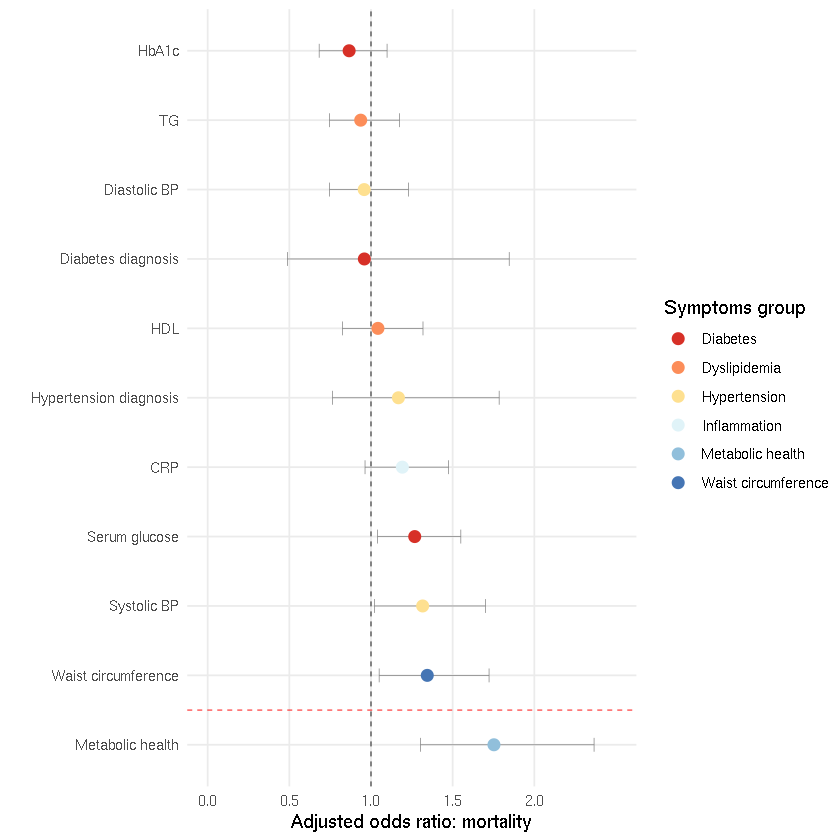

In [32]:
(p_death <- ggplot(ORs_mortality, aes(x = (V1), y = reorder(names, -V1))) + 
    geom_vline(aes(xintercept = 1), size = .25, linetype = "dashed") + 
    geom_errorbarh(aes(xmax = X97.5.., xmin = X2.5..), size = 0.2, height = 0.2, color = "gray50") +
    geom_point(size = 3, aes(color = Symptomsgroup)) +
    scale_x_continuous(breaks = c(0,0.5,1,1.5,2),
                       limits = c(0,2.5)) +
    theme_minimal() +
    theme(panel.grid.minor = element_blank()) +
    ylab("") +
    xlab("Adjusted odds ratio: mortality") + 
    #ggtitle("B") +
    scale_color_brewer(palette="RdYlBu", name='Symptoms group') +
    geom_hline(aes(yintercept = 1.5), size = .25, color='red', linetype='dashed') 
 )

ggsave('/dagher/dagher11/filip/COVID/COVID_mortality.tiff',
  plot = p_death,
  device = 'tiff',
  scale = 1,
  width = 15,
  height = 10,
  units = 'cm',
  dpi = 300
)